# Text generator model

In [ ]:
import numpy as np
import random
import tensorflow
import psycopg2
import re
from datetime import datetime
import os
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

INDEX_TO_WORD_FILE = "word_to_index.pickle"
STEPS_BEGINNING_FILE = "steps_beginning.pickle"

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### get the dataset

In [ ]:
conn = psycopg2.connect(
    host="157.230.24.228",
    database="cookix_db",
    user="cookix_user_db",
    password="f9d6UVP6gxEqueopMCiKdpjC0A5Pi5Ww",
)

cursor = conn.cursor()

cursor.execute("SELECT steps FROM recipes_recipe;")
data = cursor.fetchall()
data = [steps[0] for steps in data]

clean_data = [steps for steps in data if steps.strip() != ""]
print(f"steps recipes count: {len(clean_data)}" )
clean_data = clean_data
clean_data[:2]

steps recipes count: 10303


['Cook bacon in a skillet over medium heat until crisp.|Remove bacon from pan, reserving drippings, and crumble.|Add the shrimp to pan, and cook 2 minutes, turning once.|Combine bacon, 2 cups fennel, grape tomatoes, red onion, and baby spinach in a bowl.|Combine the remaining ingredients in a small bowl, stirring with a whisk.|Add the shrimp and balsamic mixture to spinach mixture; toss well.',
 'In a large bowl, whisk together the milk and eggs. Stir in the sour cream, spinach, asparagus, Parmesan, and salt.|Add the flour and mix until well combined.|In a large skillet, over medium heat, heat 1/3 of the oil. Make 4 pancakes (about 1/4 cup of batter per pancake) and cook until golden brown and slightly puffed, 2 to 3 minutes per side. Working in batches, make a total of 12 pancakes, adding oil as necessary.']

### text cleaning

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

def preprocess_text(sentences: list):
    
    processed_sen = []
    all_words = []
    
    stop_words = set(stopwords.words('english'))
    
    for sen in sentences:
        
        if not ("Ingredients" in sen or "Save Recipe" in sen or "Print Recipe" in sen):
            
            # replace the pipe "|" that we used for steps separation, by space
            sentence = re.sub(r"(\||:|!|\?|=|\*|\{|\}|\'|\-\-|°|\$|&|''|``|\(|\)|\[|\]|#|%)", ' ', sen.lower())
            sentence = re.sub(r"[0-9]+f|[0-9]+\-(inch)?", ' ', sentence)
            sentence = re.sub(r';', ',', sentence)
            sentence = re.sub(r"\-?>", ',', sentence)
            
            # replace numbers by [number] (valid for 5, 5555, 55-5555 ....)
            sentence = re.sub(r"\s+[0-9]+((\-|/)[0-9]*)*\s+", ' __NUMBER__ ', sentence)
            sentence = re.sub(r"[0-9]+/?[0-9]*", ' __NUMBER__ ', sentence)
            sentence = re.sub(r'(type_27_data|init_step_by_step_images)', ' ', sentence)
            # remove brackets
            sentence = re.sub(r'\(.+\)', ' ', sentence)
            # remove meaningless comments
            sentence = re.sub(r'Serves.*', ' ', sentence)
            # remove meaningless comments
            sentence = re.sub(r'reprinted.*', ' ', sentence)
            
            sentence = re.sub(r'\.', ' . ', sentence)
            # Removing multiple spaces
            sentence = re.sub(r'\s+', ' ', sentence.strip())
            sen_tokens = word_tokenize(sentence)
            #sen_tokens = [w for w in sen_tokens if not w in stop_words]
            sentence = [lemmatizer.lemmatize(w) for w in sen_tokens]
            [all_words.append(w) for w in sentence]
            processed_sen.append(sentence)    

    return processed_sen, all_words

processed_sen, all_words = preprocess_text(clean_data)

n_words = len(all_words)
unique_words = list(set(all_words))
n_unique_words = len(unique_words)

print('Total Words: %d' % n_words)
print('Unique Words: %d' % n_unique_words)
# Total Words: 1079113
# Unique Words: 11631

Total Words: 1559139
Unique Words: 11759


### transform word to index

In [ ]:
word_to_index, index_to_word = {}, {}
for i, w in enumerate(unique_words): 
    index_to_word[i] = w
    word_to_index[w] = i

input_sequence = []
output_words = []
steps_beginning_idx = []
input_seq_length = 15

for sen in processed_sen:
    for i in range(len(sen) - input_seq_length):
        in_seq = sen[i:i + input_seq_length]
        out_seq = sen[i + input_seq_length]
        in_seq_index = [word_to_index[word] for word in in_seq]
        input_sequence.append(in_seq_index)
        output_words.append(word_to_index[out_seq])
        if i == 0 and in_seq_index not in steps_beginning_idx: 
            steps_beginning_idx.append(in_seq_index)
            

X = np.reshape(input_sequence, (len(input_sequence), input_seq_length, 1))
# X = X / float(vocab_size)
# y = to_categorical(output_words)
y = np.array(output_words.copy())
y = np.reshape(y, (y.shape[0], 1))
print("X shape:", X.shape)
print("y shape:", y.shape)

# save our variables

with open(INDEX_TO_WORD_FILE, 'wb') as file:
    pickle.dump(index_to_word, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(STEPS_BEGINNING_FILE, 'wb') as file:
    pickle.dump(steps_beginning_idx, file, protocol=pickle.HIGHEST_PROTOCOL)

X shape: (1406391, 15, 1)
y shape: (1406391, 1)


### Model training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


EPOCHS = 100
LOSS = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

model = Sequential()
model.add(Embedding(n_unique_words, 200))
model.add(LSTM(200))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_unique_words, activation='softmax'))

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
current_time = datetime.today().strftime("%Y%m%d%H%M")
TEXT_GEN_WEIGHTS_NAME = f"gen_weights_{current_time}_seq{input_seq_length}_{X.shape[0]}sen_{n_unique_words}vocab_ep{EPOCHS}.h5"

print(TEXT_GEN_WEIGHTS_NAME)
checkpoint = ModelCheckpoint(TEXT_GEN_WEIGHTS_NAME, monitor='loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min')

history = model.fit(X, y, batch_size=256, epochs=EPOCHS, verbose=1, callbacks=[checkpoint])

# model.load_weights(TEXT_GEN_WEIGHTS_NAME+".hdf5")
# model.compile(loss=LOSS, optimizer=OPTIMIZER)
# os.remove(TEXT_GEN_WEIGHTS_NAME+".hdf5")
model.save(TEXT_GEN_WEIGHTS_NAME)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2351800   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

KeyboardInterrupt: ignored

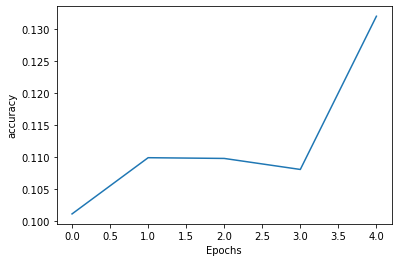

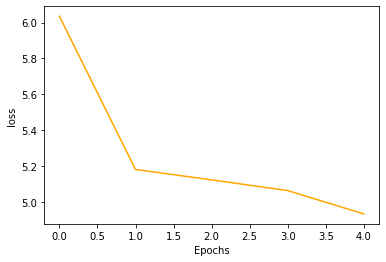

Random sentence: 'melt butter large saucepan'


In [ ]:
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

plt.plot(history.history["loss"], c="orange")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

# model = load_model(TEXT_GEN_WEIGHTS_NAME+".h5")
# model.load_weights(TEXT_GEN_WEIGHTS_NAME+".hdf5")
# model.compile(loss=LOSS, optimizer=OPTIMIZER)
with open(INDEX_TO_WORD_FILE, 'rb') as file:
    index_to_word = pickle.load(file)

with open(STEPS_BEGINNING_FILE, 'rb') as file:
    steps_beginning_idx = pickle.load(file)


random_seq_index = np.random.randint(0, len(steps_beginning_idx)-1)
random_seq = steps_beginning_idx[random_seq_index]

word_sequence = [index_to_word[value] for value in random_seq]
random_sen = ' '.join(word_sequence)
print(f"Random sentence: '{random_sen}'")

### word generating

In [ ]:
def generate_sentences(model, input_sentence: list, steps_count: int=10):

    with open(INDEX_TO_WORD_FILE, 'rb') as file:
        index_to_word = pickle.load(file)


    input_sentence_list = input_sentence.copy()
    word_to_index = {v: k for k, v in index_to_word.items()}

    stop_words = set(stopwords.words('english'))
    stop_words_idx = [word_to_index[w] for w in stop_words if w in word_to_index.keys()]

    sentences_delimiter = word_to_index["."]
    generated_sen_count = input_sentence_list.count(sentences_delimiter)
    input_seq_length = len(input_sentence_list) # model.input_shape[1]


    words_count = 0
    while generated_sen_count <= steps_count:
        input_sentence_arr = np.reshape(input_sentence_list[-input_seq_length:], (1, input_seq_length, 1))

        predicted_word_index = model.predict(input_sentence_arr, verbose=0)
        predicted_idx_asc = np.argsort(predicted_word_index, axis=1, kind='quicksort')
        predicted_word_id = predicted_idx_asc[:,-1][0]
        keeped_length_words = min(len(input_sentence_list), 15)
        last_N_words = input_sentence_list[-keeped_length_words:]
        i = 2
        while predicted_word_id not in stop_words_idx and predicted_word_id in last_N_words\
                and predicted_word_id not in [word_to_index["."], word_to_index[","]] :
            i += 1

        input_sentence_list.append(predicted_word_id)
        if predicted_word_id == sentences_delimiter : generated_sen_count += 1
        words_count += 1
        if words_count >= 50: break

    words_seq = [index_to_word[index] for index in input_sentence_list]
    final_output = " ".join(words_seq)

    return final_output


generate_sentences(model, random_seq, steps_count=5)